In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from os import listdir
from tensorflow.keras.layers import LSTM, Dense
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix


In [2]:
# Analyze to load data in batch
# https://stackoverflow.com/questions/61891990/how-to-load-npy-files-from-different-directories-in-tensorflow-data-pipeline-fr

In [3]:
data_path = "./data/train_cnn_features_v2"
train_examples = []
train_labels = []
video_categories = listdir(data_path)
for category in video_categories:
    category_path = data_path+"/"+category
    images_files = listdir(category_path)
    for image in images_files:
        image_path = category_path+"/"+image
        cnn_features = np.load(image_path)["arr_0"]
        train_examples.append(cnn_features)
        train_labels.append(category)

In [4]:
MAX_SEQ_LENGTH = 242
NUM_FEATURES = 1280
EPOCHS = 50
BATCH_SIZE = 64
CLASSES = list(set(train_labels))
N_CLASSES = len(CLASSES)

In [5]:
labels_mapping = dict(zip(CLASSES, range(N_CLASSES)))

In [6]:
train_labels_ids = [labels_mapping[case] for case in train_labels]

In [7]:
labels_one_hot = tf.one_hot(train_labels_ids, N_CLASSES)

In [8]:
X_train, X_test, y_train_ids, y_test_ids = train_test_split(train_examples, train_labels_ids, test_size=0.33, random_state=42)

In [9]:
y_train = tf.one_hot(y_train_ids, N_CLASSES)
y_test = tf.one_hot(y_test_ids, N_CLASSES)

In [10]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train)).batch(BATCH_SIZE)
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(BATCH_SIZE)
#train_dataset = tf.data.Dataset.from_tensor_slices((train_examples, labels_one_hot)).batch(BATCH_SIZE)

In [11]:
model = keras.Sequential()
model.add(keras.Input(shape=(MAX_SEQ_LENGTH, NUM_FEATURES))) 
model.add(LSTM(256, return_sequences=True))
model.add(LSTM(124))
model.add(Dense(N_CLASSES*2))
model.add(Dense(N_CLASSES, activation="softmax"))

opt = keras.optimizers.Adam(learning_rate=0.01)
model.compile(loss="categorical_crossentropy", 
              optimizer=opt,
              metrics=["accuracy"])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 242, 256)          1573888   
                                                                 
 lstm_1 (LSTM)               (None, 124)               188976    
                                                                 
 dense (Dense)               (None, 128)               16000     
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
Total params: 1,787,120
Trainable params: 1,787,120
Non-trainable params: 0
_________________________________________________________________


In [12]:
filepath = "./trained_models/video_classifier_rnn/"
checkpoint = keras.callbacks.ModelCheckpoint(filepath, 
                                             save_weights_only=True,
                                             save_best_only=True,
                                             verbose=1)
history = model.fit(train_dataset, validation_data=test_dataset, #callbacks=[checkpoint],
                    epochs=EPOCHS)

Epoch 1/50
33/33 [==============================] - 11s 190ms/step - loss: 4.1564 - accuracy: 0.0196 - val_loss: 4.1045 - val_accuracy: 0.0311
Epoch 2/50
33/33 [==============================] - 6s 166ms/step - loss: 4.2408 - accuracy: 0.0220 - val_loss: 4.1611 - val_accuracy: 0.0194
Epoch 3/50
33/33 [==============================] - 5s 163ms/step - loss: 4.2728 - accuracy: 0.0148 - val_loss: 4.1655 - val_accuracy: 0.0165
Epoch 4/50
33/33 [==============================] - 6s 175ms/step - loss: 4.1494 - accuracy: 0.0225 - val_loss: 4.1021 - val_accuracy: 0.0165
Epoch 5/50
33/33 [==============================] - 5s 167ms/step - loss: 3.9333 - accuracy: 0.0321 - val_loss: 3.8385 - val_accuracy: 0.0252
Epoch 6/50
33/33 [==============================] - 5s 163ms/step - loss: 3.8362 - accuracy: 0.0278 - val_loss: 3.8030 - val_accuracy: 0.0330
Epoch 7/50
33/33 [==============================] - 6s 169ms/step - loss: 3.8226 - accuracy: 0.0234 - val_loss: 3.7866 - val_accuracy: 0.0320
Epoch

In [13]:
predictions_test = model.predict(np.array(X_test))

In [14]:
predictions_class_test = np.argmax(predictions_test, axis =1)

In [15]:
y_true = y_test_ids
y_pred =  predictions_class_test
# Confusion matrix for actual and predicted values.
cm = confusion_matrix(y_true, y_pred)

In [16]:
# Creating a dataframe for a array-formatted Confusion matrix,so it will be easy for plotting.
cm_df = pd.DataFrame(cm,
                     index = CLASSES, 
                     columns = CLASSES)

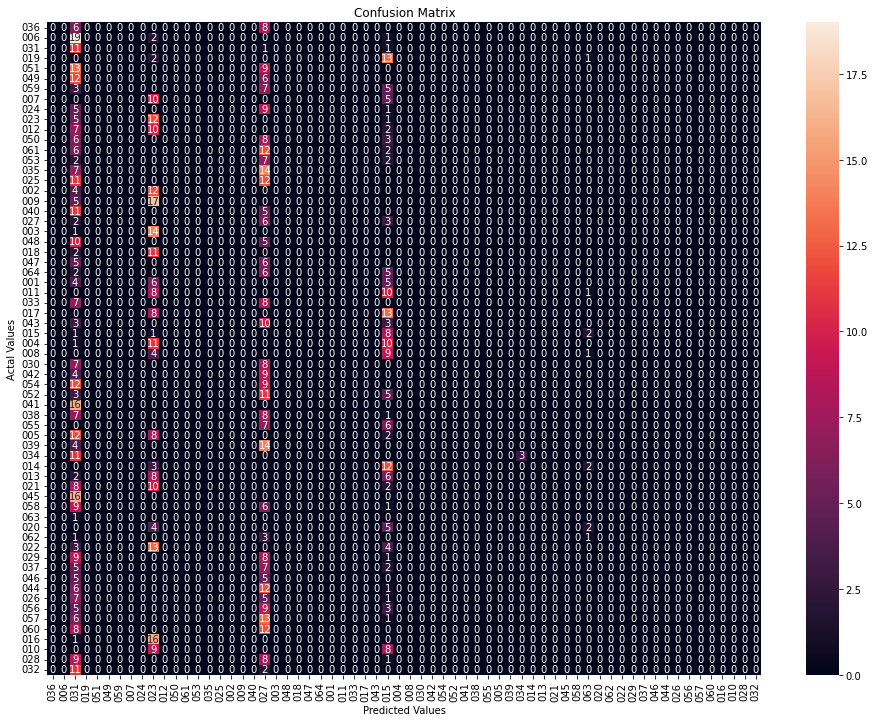

In [17]:
#Plotting the confusion matrix
plt.figure(figsize=(16,12))
sns.heatmap(cm_df, annot=True)
plt.title('Confusion Matrix')
plt.ylabel('Actal Values')
plt.xlabel('Predicted Values')
plt.show()
